# One-Dimensional linear Aquifer Storage and Recovery with MODFLOW6 and Flopy

In this notebook, we will learn how to:
1. Simulate both injection and recovery of freshwater.
2. Compute the recovery efficiency

In [1]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 3) # set default figure size
import flopy as fp  # import flopy and call it fp

## Description of the flow problem
Consider one-dimensional flow in a semi-infinite confined aquifer. The aquifer extends from $x=0$ to $x=L$ in the $x$ direction, where $L$ is chosen far enough away not to effect the flow solution.  Water is injected at the left side at a rate $U$ such that the average velocity in the aquifer is 1 m/d. The head is fixed on the right side to $h_R$. Flow is considered to be at steady state instantaneously. 

The initial salt concentration is equal to $c_s$ everywhere. Injection of fresh water with concentration $c_f$ starts at $t=0$ and lasts for $t_\text{in}$ days, after which water is extracted at the same rate $U$ for $t_\text{out}$ days.

Changes in the parameter block are:
* Time discretization
* Model name

In [2]:
# domain size and boundary conditions
L = 80 # length of domain, m
hR = 0 # head at right side of domain

# aquifer parameters
k = 20 # hydraulic conductivity, m/d
H = 20 # aquifer thickness, m
npor = 0.25 # porosity, -

# flow
vavg = 1 # average velocity, m/d
U = vavg * npor * H # computed total inflow, m^2/d

# transport
alphaL = 0.1 # longitudinal dispersivity in horizontal direction, m
alphaT = alphaL / 10 # transverse dispersivity is 10 times smaller than longitudinal, m
diffusion_coef = 0 # diffusion is not modeled

# concentration
cs = 35 # initial concentration, kg/m^3 (=g/L)
cf = 0 # concentration injected water, kg/m^3 (=g/L)

# space discretization
delr = 0.2 # length of cell along row (in x-direction), m
delc = 1 # width of cells normal to plane of flow (in y-direction), m
z = [0, -H] # top and bottom(s) of layers
nlay = 1 # number of layers
nrow = 1 # number of rows
ncol = round(L / delr) # number of columns
xg = np.cumsum(delr * np.ones(ncol)) - delr / 2 # centers of grid cells, m

# time discretization
tin = 40 # injection time, d
delt = 0.1 # time step, d
nstepin = round(tin / delt) # computed number of steps during injection, integer
tout = 40 # extraction time, d
delt = 0.1 # time step, d
nstepout = round(tout / delt) # computed number of steps during extraction, integer

# model name and workspace
modelname = 'model1d_cycle' # name of model
gwfname = modelname + 'f' # name of flow model
gwtname = modelname + 't' # name of transport model
modelws = './' + modelname # model workspace to be used

## Create Simulation
Changes in the simulation are:
* Number of stress periods is now 2
* Period data for both periods

In [3]:
# simulation
sim = fp.mf6.MFSimulation(sim_name=modelname, # name of simulation
                          version='mf6', # version of MODFLOW
                          exe_name='../bin/mf6', # path to MODFLOW executable
                          sim_ws=modelws, # path to workspace where all files are stored
                         )

# time discretization
tdis = fp.mf6.ModflowTdis(simulation=sim, # add to the simulation called sim (defined above)
                          time_units="DAYS", 
                          nper=2, # number of stress periods 
                          perioddata=[[tin, nstepin, 1],
                                      [tout, nstepout, 1]], # period length, number of steps, timestep multiplier
                         )

## Create groundwater flow model (`gwf`)
Changes in the groundwater flow model:
* Stress period data for the well
* No change in stress period data for constant head needed. MODFLOW uses the stress period data of the last stress period when no new data is defined. 

In [4]:
# groundwater flow model
gwf = fp.mf6.ModflowGwf(simulation=sim, # add to simulation called sim
                        modelname=gwfname, # name of gwf model
                        save_flows=True, # make sure all flows are stored in binary output file
                       )

# iterative model solver
gwf_ims  = fp.mf6.ModflowIms(simulation=sim, # add to simulation called sim
                             filename=gwf.name + '.ims', # file name to store ims
                             linear_acceleration="BICGSTAB", # use BIConjuGantGradientSTABalized method
                            )                                                                                                
# register solver
sim.register_ims_package(solution_file=gwf_ims, # name of iterative model solver instance
                         model_list=[gwf.name], # list with name of groundwater flow model
                        )   

# discretization
gwf_dis = fp.mf6.ModflowGwfdis(model=gwf, # add to groundwater flow model called gwf
                               nlay=nlay, 
                               nrow=nrow, 
                               ncol=ncol, 
                               delr=delr, 
                               delc=delc, 
                               top=z[0], 
                               botm=z[1:], 
                              )

# aquifer properties
gwf_npf  = fp.mf6.ModflowGwfnpf(model=gwf, 
                                k=k, # horizontal k value
                                save_flows=True, # save the flow for all cells
                               )
    
# initial condition
gwf_ic = fp.mf6.ModflowGwfic(model=gwf, 
                             strt=hR, # initial head used for iterative solution
                            )

# wells
wellin = [[(0, 0, 0),  U, cf]]   # [(layer, row, col), U, concentration]
wellout = [[(0, 0, 0),  -U, cf]] # specified concentration is not used for extraction, but must be specified 
wel_spd = {0: wellin, 1: wellout} # stress period data for periods 0 and 1
gwf_wel = fp.mf6.ModflowGwfwel(model=gwf, 
                               stress_period_data=wel_spd, 
                               auxiliary=['CONCENTRATION'],
                               pname='WEL1', # package name
                              )

# constant head 
chd0 = [[(0,  0,  ncol-1), hR, cs]] # [(layer, row, col), head, concentration]
chd_spd  = {0: chd0} # stress period data
gwf_chd = fp.mf6.ModflowGwfchd(model=gwf, 
                               stress_period_data=chd_spd, 
                               auxiliary=['CONCENTRATION'],
                               pname='CHD1', # package name
                              )
    
# output control
oc = fp.mf6.ModflowGwfoc(model=gwf, 
                         saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")], # what to save
                         budget_filerecord=f"{gwfname}.cbc", # file name where all budget output is stored
                         head_filerecord=f"{gwfname}.hds", # file name where all head output is stored
                        )

## Create groundwater transport model (`gwt`)
Changes in the transport model: None.

In [5]:
# groundwater transport model
gwt = fp.mf6.ModflowGwt(simulation=sim, 
                        modelname=gwtname, # name of groundwater transport model
                       )

# iterative model solver
gwt_ims  = fp.mf6.ModflowIms(simulation=sim, # add to simulation
                             filename=gwt.name + '.ims', # must be different than file name of gwf model ims
                             linear_acceleration="BICGSTAB",
                            ) 
sim.register_ims_package(solution_file=gwt_ims, 
                         model_list=[gwt.name],
                        )

# discretization
gwt_dis = fp.mf6.ModflowGwtdis(model=gwt, # add to gwt model
                               nlay=nlay, 
                               nrow=nrow, 
                               ncol=ncol, 
                               delr=delr, 
                               delc=delc, 
                               top=z[0], 
                               botm=z[1:], 
                              )

# mobile storage and transfer
gwt_sto = fp.mf6.ModflowGwtmst(model=gwt, 
                               porosity=npor, # porosity
                               save_flows=True,
                              )

# initial condition
gwt_ic = fp.mf6.ModflowGwtic(model=gwt, 
                             strt=cs, # initial concentration
                            ) 

# source sink mixing
sourcelist = [("WEL1", "AUX", "CONCENTRATION"), ("CHD1", "AUX", "CONCENTRATION")] # list of (pname, 'AUX', 'CONCENTRATION')
ssm = fp.mf6.ModflowGwtssm(model=gwt, 
                           sources=sourcelist, 
                           save_flows=True,
                           pname='SSM1', 
                          )

# advection
adv = fp.mf6.ModflowGwtadv(model=gwt,  
                           scheme="TVD", # use the Total Variation Diminishing (TVD) method
                           pname='ADV1',
                          )

# dispersion
dsp = fp.mf6.ModflowGwtdsp(model=gwt, 
                           alh=alphaL, # longitudinal dispersivity
                           ath1=alphaT, # transverse dispersivity
                           diffc=diffusion_coef, # diffusion coefficient
                           pname='DSP1', 
                          )

# output control
oc = fp.mf6.ModflowGwtoc(model=gwt,
                         saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")], # what to save
                         budget_filerecord=f"{gwtname}.cbc", # file name where all budget output is stored
                         concentration_filerecord=f"{gwtname}.ucn", # file name where all concentration output is stored
                        )

Changes in interaction: None

In [6]:
fp.mf6.ModflowGwfgwt(simulation=sim, 
                     exgtype="GWF6-GWT6", 
                     exgmnamea=gwf.name, # name of groundwater flow model 
                     exgmnameb=gwt.name, # name of transport model
                     filename=f"{modelname}.gwfgwt",
                    );

## Write input files and solve model

In [7]:
sim.write_simulation(silent=True)
success, _ = sim.run_simulation(silent=True) 
if success == 1:
    print('Model solved successfully')
else:
    print('Solve failed')

Model solved successfully


## Read head data and make plot
Plot the head at t=0.1 and at t=40.1.

In [8]:
hds = gwf.output.head() # get handle to binary head file
head = hds.get_alldata().squeeze() # get all the head data from the file
times = np.array(hds.get_times()) # get times and make it an array
print(f'min, max head in model: {head.min():.2f}, {head[0].max():.2f} m')

min, max head in model: -1.00, 1.00 m


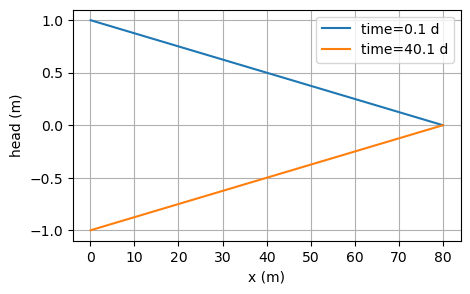

In [9]:
for t in [0.1, 40.1]:
    itime = np.abs(times - t).argmin() # index of time closest to t         
    plt.plot(xg, head[itime, :], label=f'time={times[itime]} d')
plt.xlabel('x (m)')
plt.ylabel('head (m)')
plt.legend()
plt.grid()

## Read concentration data and make plot

Plot the concentration vs. $x$ at 10 day intervals. Make separate plots for the injection and extraction periods.

In [10]:
cobj = gwt.output.concentration() # get handle to binary concentration file
c = cobj.get_alldata().squeeze() # get the concentration data from the file
times = np.array(cobj.get_times()) # get the times and convert to array

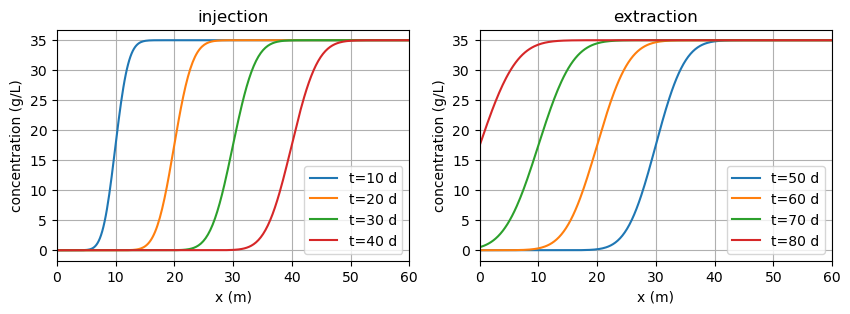

In [11]:
# plot concentration vs. x for three different times   
plt.figure(figsize=(10, 3))
plt.subplot(121)
for t in np.arange(10, 41, 10):
    itime = np.abs(times - t).argmin() # find index of value in times closest to t
    plt.plot(xg, c[itime,:], label=f't={times[itime]:.0f} d')
plt.title('injection')
plt.xlabel('x (m)')
plt.ylabel('concentration (g/L)')
plt.xlim(0, 60)
plt.legend()
plt.grid()
plt.subplot(122)
for t in np.arange(50, 81, 10):
    itime = np.abs(times - t).argmin() # find index of value in times closest to t
    plt.plot(xg, c[itime,:], label=f't={times[itime]:.0f} d')
plt.title('extraction')
plt.xlabel('x (m)')
plt.ylabel('concentration (g/L)')
plt.xlim(0, 60)
plt.legend()
plt.grid()

## Recovery efficiency
Determine the first time when the concentration of the extracted water exceeds $c_\text{limit}=1$ kg/m$^3$ (g/L). 

In [12]:
climit = 1 # limit concentration, kg/m^3 (g/L)
for itime in range(400, 800):
    if c[itime, 0] > climit:
        break
print(f'first time when c exceeds climit: {round(times[itime], 2)} d when concentration is {c[itime, 0]:.2f} g/L')

first time when c exceeds climit: 71.2 d when concentration is 1.04 g/L


The recovery efficiency is defined as the volume of extacted water with a concentration below $c_\text{limit}$ divided by the volume of injected water. 

In [13]:
rec_eff = ((times[itime - 1] - tin) * U) / (tin * U) # U not needed when injection and extraction rates are the same
print(f'recovery efficiency = {rec_eff * 100:.1f} %')

recovery efficiency = 77.7 %


## Mass balance
During a time step, freshwater with concentration $c_f$ flows into the system at a rate $U$, while saltwater with concentration $c_s$ flows out of the system at a rate $U$ (recall that flow is stationary). Hence, the change in mass of salt $\Delta M_1$ (positive for an increase in mass) in the system during a time step is \begin{equation}
\Delta M_1 = (U c_f - U c_s)\Delta t
\end{equation}
If the mass balance is met, this change in mass must be equal to the change in mass in the system $\Delta M_2$
\begin{equation}
\Delta M_2 = \sum_i{(c_i(t)-c_i(t-\Delta t) H n\Delta x}
\end{equation}
where $\Delta x$ is the cell size in $x$-direction (i.e., `delr`). The mass balance is computed for one time step as follows 

We are considering the mass balance during extraction. During a time step, water with concentration $c_0$ (the concentration in the first cell) flows out of the system at a rate $U$, while saltwater with concentration $c_s$ flows into the system at a rate $U$, so that
\begin{equation}
\Delta M_1 = (-U c_0 + U c_s)\Delta t
\end{equation}
Plot the change in mass during the extraction period vs. the time step. Plot both $\Delta M1$ and $\Delta M2$ in one graph. Don't forget to add a legend.

Text(0.5, 1.0, 'Mass change versus time during extraction period')

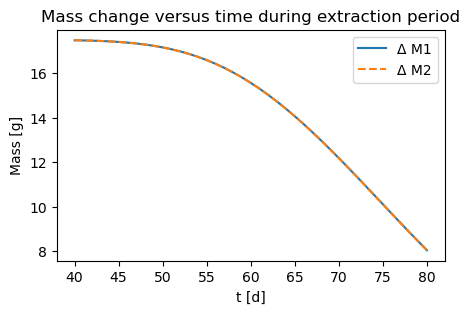

In [111]:
time = np.arange(40,81,1)
delM1 = np.zeros(len(time))
delM2 = np.zeros(len(time))

for i,t in enumerate (time):  
    itime = np.abs(times - t).argmin()
    delM1[i]= (-U * c[itime,0] + U * c[itime,-1]) * delt
    delM2[i] = np.sum((c[itime-1] - c[itime]) * H * npor * delr)
    
plt.figure()
plt.plot(time, delM1, label = 'Δ M1')
plt.plot(time, delM2, ls='--', label = 'Δ M2')
plt.legend()
plt.xlabel('t [d]')
plt.ylabel('Mass [g]')
plt.title('Mass change versus time during extraction period')


In [ ]:







plt.figure()
plt.plot(time, delM1, label = 'deltaM1')
plt.plot(time, delM2, label = 'deltaM2')
plt.legend()
plt.xlabel('t [d]')
plt.ylabel('Mass [kg]')
plt.title('Mass change versus time')


## Make change to model
Changes can be made to one or more packages. The new package will replace the old package (if the `pname` is the same).
After the package(s) are changed, the simulation must be rewritten and resolved, and the solution must be read in from the binary file. 

In the following example, the injection and extraction rate $U$ is changed from 5 to 10 m$^2$/d. Note that `flopy` gives a warning that the old wel1 package is replaced with the new wel1 package. After the change in the wel package, the model is rewritten, resolved, and the concentration data is read in again.

In [15]:
# redefine the injection rate 
#U = 10 # m^2/d
wellin = [[(0, 0, 0),  U, cf]]   # [(layer, row, col), U, concentration]
wellout = [[(0, 0, 0),  -U, cf]] # specified concentration is not used, but must be specified 
wel_spd = {0: wellin, 1: wellout} # stress period data for periods 0 and 1
gwf_wel = fp.mf6.ModflowGwfwel(model=gwf, 
                               stress_period_data=wel_spd, 
                               auxiliary=['CONCENTRATION'],
                               pname='WEL1', # package name
                              )

In [16]:
# write model, solve model, and read concentration data
sim.write_simulation(silent=True)
success, _ = sim.run_simulation(silent=True) 
if success == 1:
    print('Model solved successfully')
else:
    print('Solve failed')

cobj = gwt.output.concentration() # get handle to binary concentration file
c = cobj.get_alldata().squeeze() # get the concentration data from the file
times = np.array(cobj.get_times()) # get the times and convert to array

Model solved successfully


Compute the recovery efficiency for this case. Note that a larger infiltration volume gives a larger recovery efficiency.

In [17]:
climit = 1 # limit concentration, g/L
for itime in range(400, 800):
    if c[itime, 0] > climit:
        break
print(f'first time when c exceeds climit: {round(times[itime], 2)} d when concentration is {c[itime, 0]:.2f} g/L')
rec_eff = ((times[itime - 1] - tin) * U) / (tin * U) # U not needed when injection and extraction rates are the same
print(f'recovery efficiency = {rec_eff * 100:.1f} %')

first time when c exceeds climit: 71.2 d when concentration is 1.04 g/L
recovery efficiency = 77.7 %


## Homework
Use the parameters defined in the code block at the beginning of this notebook (don't forget to reset the injection rate $U$ as we changed that in the previous example).

### Problem 3
We are considering the mass balance during extraction. During a time step, water with concentration $c_0$ (the concentration in the first cell) flows out of the system at a rate $U$, while saltwater with concentration $c_s$ flows into the system at a rate $U$, so that
\begin{equation}
\Delta M_1 = (-U c_0 + U c_s)\Delta t
\end{equation}
Plot the change in mass during the extraction period vs. the time step. Plot both $\Delta M1$ and $\Delta M2$ in one graph. Don't forget to add a legend.

### Problem 4
Compute the recovery efficiency when $c_\text{limit} = 500$ mg/L, $t_\text{in}=40$ d, and $\alpha_L=0.5$ m by changing the dispersion package of the transport model. 

### Problem 5
Compute the recovery efficiency when $c_\text{limit} = 500$ mg/L, $t_\text{in}=100$ d, and $\alpha_L=0.5$ m by changing the length of the input and output times in the simulation.

### Problem 6
Compute the recovery efficiency when $c_\text{limit} = 500$ mg/L, $t_\text{in}=40$ d, and $\alpha_L$ varies from 0.1 m to 2 m. Plot the recovery efficiency (vertical axis) vs. the dispersivity (horizontal axis). 

In [18]:
# redefine transport model
alphaL = 0.5

# dispersion
dsp = fp.mf6.ModflowGwtdsp(model=gwt, 
                           alh=alphaL, # longitudinal dispersivity
                           ath1=alphaT, # transverse dispersivity
                           diffc=diffusion_coef, # diffusion coefficient
                           pname='DSP1', 
                          )

In [19]:
# write model, solve model, and read concentration data
sim.write_simulation(silent=True)
success, _ = sim.run_simulation(silent=True) 
if success == 1:
    print('Model solved successfully')
else:
    print('Solve failed')

cobj = gwt.output.concentration() # get handle to binary concentration file
c = cobj.get_alldata().squeeze() # get the concentration data from the file
times = np.array(cobj.get_times()) # get the times and convert to array

Model solved successfully


In [20]:
climit = 0.5 # limit concentration, g/L
for itime in range(400, 800):
    if c[itime, 0] > climit:
        break
print(f'first time when c exceeds climit: {round(times[itime], 2)} d when concentration is {c[itime, 0]:.2f} g/L')
rec_eff = ((times[itime - 1] - tin) * U) / (tin * U) # U not needed when injection and extraction rates are the same
print(f'recovery efficiency = {rec_eff * 100:.1f} %')

first time when c exceeds climit: 61.7 d when concentration is 0.50 g/L
recovery efficiency = 54.0 %


In [21]:
alphaL1 = np.arange(0,2,0.1)
rec_eff = np.zeros(len(alphaL1))
for i in range(len(alphaL1)):
    alphaL = alphaL1[i]
    
    # dispersion
    dsp = fp.mf6.ModflowGwtdsp(model=gwt, 
                               alh=alphaL, # longitudinal dispersivity
                               ath1=alphaT, # transverse dispersivity
                               diffc=diffusion_coef, # diffusion coefficient
                               pname='DSP1', 
                              )
    sim.write_simulation(silent=True)
    success, _ = sim.run_simulation(silent=True) 
    if success == 1:
        print('Model solved successfully')
    else:
        print('Solve failed')

    cobj = gwt.output.concentration() # get handle to binary concentration file
    c = cobj.get_alldata().squeeze() # get the concentration data from the file
    times = np.array(cobj.get_times()) # get the times and convert to array
    
    climit = 0.5 # limit concentration, g/L
    for itime in range(400, 800):
        if c[itime, 0] > climit:
            break
    
    rec_eff[i] = ((times[itime - 1] - tin) * U) / (tin * U) # U not needed when injection and extraction rates are the same
    
    


Model solved successfully
Model solved successfully
Model solved successfully
Model solved successfully
Model solved successfully
Model solved successfully
Model solved successfully
Model solved successfully
Model solved successfully
Model solved successfully
Model solved successfully
Model solved successfully
Model solved successfully
Model solved successfully
Model solved successfully
Model solved successfully
Model solved successfully
Model solved successfully
Model solved successfully
Model solved successfully


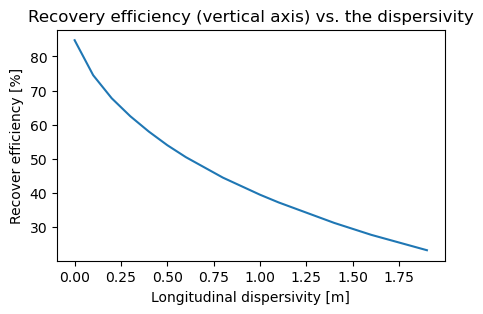

In [22]:

#print(f'first time when c exceeds climit: {round(times[itime], 2)} d when concentration is {c[itime, 0]:.2f} g/L')
#print(f'recovery efficiency = {rec_eff * 100:.1f} %')
rec_eff_perc = rec_eff*100
plt.figure
plt.title('Recovery efficiency (vertical axis) vs. the dispersivity')
plt.xlabel('Longitudinal dispersivity [m]')
plt.ylabel('Recover efficiency [%]')
plt.plot(alphaL1,rec_eff_perc)
          

In [23]:
tin = 100
delt = 0.1 # time step, d
nstepin = round(tin / delt) # computed number of steps during injection, integer
tout = 100
delt = 0.1 # time step, d
nstepout = round(tout / delt)


# change in time discretization
tdis = fp.mf6.ModflowTdis(simulation=sim, # add to the simulation called sim (defined above)
                          time_units="DAYS", 
                          nper=2, # number of stress periods 
                          perioddata=[[tin, nstepin, 1],
                                      [tout, nstepout, 1]], # period length, number of steps, timestep multiplier
                         )

In [24]:
# write model, solve model, and read concentration data
sim.write_simulation(silent=True)
success, _ = sim.run_simulation(silent=True) 
if success == 1:
    print('Model solved successfully')
else:
    print('Solve failed')

cobj = gwt.output.concentration() # get handle to binary concentration file
c = cobj.get_alldata().squeeze() # get the concentration data from the file
times = np.array(cobj.get_times()) # get the times and convert to array

Model solved successfully


In [25]:
climit = 0.5 # limit concentration, g/L
for itime in range(400, 1400):
    if c[itime, 0] > climit:
        break
print(f'first time when c exceeds climit: {round(times[itime], 2)} d when concentration is {c[itime, 0]:.2f} g/L')
rec_eff = ((times[itime - 1] - tin) * U) / (tin * U) # U not needed when injection and extraction rates are the same
print(f'recovery efficiency = {rec_eff * 100:.1f} %')

first time when c exceeds climit: 140.0 d when concentration is 0.22 g/L
recovery efficiency = 39.9 %
